Libraries

In [1]:
import math
import itertools
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from haversine import haversine, Unit
import networkx as nx

from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch.utils.data import DataLoader as TorchLoader 

In [2]:
torch.backends.cudnn.enabled = False
device = torch.device('cpu')
print("Using device:", device)

Using device: cpu


In [3]:
original_data = pd.read_csv('2.csv')
original_data.rename(columns={'last': 'DateTime'}, inplace=True)
original_data['DateTime'] = pd.to_datetime(original_data['DateTime'])
original_data['cell_id'] = original_data.groupby(['devicelat','devicelon']).ngroup() + 1
desired_range = pd.date_range(start='2025-03-28', end='2025-07-29', freq='1H')
final_data = pd.DataFrame()
for cid, dfc in original_data.groupby('cell_id'):
    temp = pd.DataFrame(index=desired_range)
    temp['devicelon'] = dfc['devicelon'].iloc[0]
    temp['devicelat'] = dfc['devicelat'].iloc[0]
    grouped = (dfc.set_index('DateTime')
                 .groupby(pd.Grouper(freq='1H'))
                 .mean(numeric_only=True))
    temp[['pm25','pm10','Hum','Temp(cel)']] = grouped[['pm25','pm10','Hum','Temp(cel)']]
    temp['cell_id'] = cid
    final_data = pd.concat([final_data, temp])
final_data.index.name = 'DateTime'
final_data = final_data.sort_index()


In [4]:
# --- Sanity checks / alignment ---
assert 'final_data' in globals(), "final_data must exist (see optional builder above)."
assert isinstance(final_data.index, pd.DatetimeIndex), "final_data must have a DatetimeIndex"
final_data.index = final_data.index.floor('H')  # ensure exact hourly stamps
print("Rows:", len(final_data), "Unique cells:", final_data['cell_id'].nunique())
print("Date range:", final_data.index.min(), "→", final_data.index.max())

Rows: 17718 Unique cells: 6
Date range: 2025-03-28 00:00:00 → 2025-07-29 00:00:00


Graph creation

In [26]:
def create_graph_for_hour(df_hour, radius_km=1.0):
    g = nx.Graph()
    if df_hour is None or df_hour.empty:
        return g
    # Add nodes
    for _, r in df_hour.iterrows():
        cid = int(r['cell_id'])
        g.add_node(cid,
                   devicelon=float(r['devicelon']),
                   devicelat=float(r['devicelat']),
                   pm25=float(r['pm25']) if pd.notna(r['pm25']) else np.nan,
                   Hum=float(r['Hum']) if pd.notna(r['Hum']) else np.nan,
                   **{'Temp(cel)': float(r['Temp(cel)']) if pd.notna(r['Temp(cel)']) else np.nan})
    node_ids = list(g.nodes())
    for a, b in itertools.combinations(node_ids, 2):
        la, loa = g.nodes[a]['devicelat'], g.nodes[a]['devicelon']
        lb, lob = g.nodes[b]['devicelat'], g.nodes[b]['devicelon']
        if not (math.isnan(la) or math.isnan(loa) or math.isnan(lb) or math.isnan(lob)):
            d = haversine((la, loa), (lb, lob), unit=Unit.KILOMETERS)
            if d <= radius_km:
                g.add_edge(a, b, weight=d)
    return g

t_min, t_max = final_data.index.min(), final_data.index.max()
timestamps = pd.date_range(t_min, t_max, freq='H')

hour_buckets = dict(tuple(final_data.groupby(level=0)))

graphs_sequence = {}
for ts in timestamps:
    df_hour = hour_buckets.get(ts, None)
    graphs_sequence[ts] = create_graph_for_hour(df_hour, radius_km=1.0)

graphs_sequence = {ts: g for ts, g in graphs_sequence.items() if g.number_of_nodes() > 0}
print("Graphs with nodes:", len(graphs_sequence))
print("Graphs with ≥1 edge:", sum(g.number_of_edges()>0 for g in graphs_sequence.values()))

Graphs with nodes: 2953
Graphs with ≥1 edge: 2953


feature matrix

In [27]:
FEATURES = ['pm25', 'Hum', 'Temp(cel)']
FEATURES_READABLE = ['PM2.5', 'Humidity', 'Temperature']  # for plotting labels

# Static node set/order:
all_nodes = sorted(list(set().union(*[set(g.nodes()) for g in graphs_sequence.values()])))
N_NODES = len(all_nodes)
print("Static node set size:", N_NODES, "Nodes:", all_nodes)

def nx_to_feature_matrix(g, node_order):
    """Return X [N, F] following node_order; mean-impute NaNs per column."""
    X = np.empty((len(node_order), len(FEATURES)), dtype=float)
    for i, n in enumerate(node_order):
        feats = [g.nodes[n].get(f, np.nan) if n in g.nodes else np.nan for f in FEATURES]
        X[i, :] = feats
    # mean-impute per column
    col_means = np.nanmean(X, axis=0)
    inds = np.where(np.isnan(X))
    X[inds] = np.take(col_means, inds[1])
    return X

X_raw_by_ts = {ts: nx_to_feature_matrix(g, all_nodes) for ts, g in graphs_sequence.items()}

Static node set size: 6 Nodes: [1, 2, 3, 4, 5, 6]


C:\Users\Admin\AppData\Local\Temp\ipykernel_5696\754357542.py:16: RuntimeWarning: Mean of empty slice
  col_means = np.nanmean(X, axis=0)


data split and scaling for normalization

In [28]:
ts_sorted = sorted(X_raw_by_ts.keys())
split_train = int(len(ts_sorted) * 0.7)
split_val   = int(len(ts_sorted) * 0.85)

train_ts = ts_sorted[:split_train]
val_ts   = ts_sorted[split_train:split_val]
test_ts  = ts_sorted[split_val:]

train_stack = np.stack([X_raw_by_ts[t] for t in train_ts], axis=0)   # [T, N, F]
train_2d = train_stack.reshape(-1, len(FEATURES))
global_scaler = StandardScaler().fit(train_2d)

# Scale all sets
def scale_dict(X_dict, scaler):
    return {ts: scaler.transform(X) for ts, X in X_dict.items()}

X_scaled_by_ts = scale_dict(X_raw_by_ts, global_scaler)

Data sequence

In [29]:
def build_pyg_from_X(ts, Xs, g, node_order):
    x = torch.tensor(Xs, dtype=torch.float)
    idx = {n: i for i, n in enumerate(node_order)}
    edges = [[idx[u], idx[v]] for u, v in g.edges() if u in idx and v in idx]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2,0), dtype=torch.long)
    return Data(x=x, edge_index=edge_index)

graphs_pyg = {ts: build_pyg_from_X(ts, X_scaled_by_ts[ts], graphs_sequence[ts], all_nodes) for ts in ts_sorted}

SEQ_LEN = 24  # hours per input sequence

def create_sequences(graphs_pyg_dict, ts_list, sequence_length):
    seqs, targs = [], []
    for i in range(len(ts_list) - sequence_length):
        window = ts_list[i:i+sequence_length]
        tgt_ts = ts_list[i+sequence_length]
        seq = [graphs_pyg_dict[t] for t in window]   # list[Data], length T
        target = graphs_pyg_dict[tgt_ts].x           # [N, F]
        seqs.append(seq)
        targs.append(target)
    return seqs, targs

train_seq, train_targ = create_sequences(graphs_pyg, train_ts, SEQ_LEN)
val_seq,   val_targ   = create_sequences(graphs_pyg, val_ts,   SEQ_LEN)
test_seq,  test_targ  = create_sequences(graphs_pyg, test_ts,  SEQ_LEN)
print("Sequences — Train/Val/Test:", len(train_seq), len(val_seq), len(test_seq))

class GraphSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, sequences, targets):
        self.sequences = sequences
        self.targets = targets
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

train_dataset = GraphSequenceDataset(train_seq, train_targ)
val_dataset   = GraphSequenceDataset(val_seq,   val_targ)
test_dataset  = GraphSequenceDataset(test_seq,  test_targ)

def collate_graph_seq(batch):
    (seqs, targs) = batch[0]
    return seqs, targs

train_loader = TorchLoader(train_dataset, batch_size=1, shuffle=True,  collate_fn=collate_graph_seq)
val_loader   = TorchLoader(val_dataset,   batch_size=1, shuffle=False, collate_fn=collate_graph_seq)
test_loader  = TorchLoader(test_dataset,  batch_size=1, shuffle=False, collate_fn=collate_graph_seq)


Sequences — Train/Val/Test: 2043 419 419


STGNN

In [30]:
input_size  = len(FEATURES)   
hidden_size = 64
num_layers  = 2
output_size = len(FEATURES)  

class STGNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super().__init__()
        self.convs = nn.ModuleList([
            GCNConv(input_size if i == 0 else hidden_size, hidden_size)
            for i in range(num_layers)
        ])
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, sequences):
        node_feats_seq = []
        for g in sequences:
            x, edge_index = g.x, g.edge_index  # x: [N, F]
            if x.numel() == 0:
                continue
            for conv in self.convs:
                x = self.relu(conv(x, edge_index))  # [N, H]
            node_feats_seq.append(x)

        # [T, N, H] -> [N, T, H]
        X = torch.stack(node_feats_seq, dim=0).permute(1, 0, 2)
        lstm_out, _ = self.lstm(X)               # [N, T, H]
        last_hidden = lstm_out[:, -1, :]         # [N, H]
        out = self.fc(last_hidden)               # [N, F]
        return out

model = STGNN(input_size, hidden_size, num_layers, output_size).to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

EPOCHS = 10
best_val = float('inf'); patience = 6; stalled = 0
train_losses, val_losses = [], []

for epoch in range(1, EPOCHS+1):
    model.train()
    tr = 0.0
    for sequences, targets in train_loader:        # sequences: list[Data], targets: [N,3]
        sequences = [g.to(device) for g in sequences]
        targets   = targets.to(device)

        optimizer.zero_grad()
        outputs = model(sequences)                 # [N,3]
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        tr += loss.item()
    tr /= max(1, len(train_loader))

    model.eval()
    va = 0.0
    with torch.no_grad():
        for sequences, targets in val_loader:
            sequences = [g.to(device) for g in sequences]
            targets   = targets.to(device)
            outputs   = model(sequences)
            loss      = criterion(outputs, targets)
            va += loss.item()
    va /= max(1, len(val_loader))

    print(f"Epoch {epoch}/{EPOCHS} | Train: {tr:.6f} | Val: {va:.6f}")
    scheduler.step(va)
    train_losses.append(tr); val_losses.append(va)

    if va < best_val:
        best_val = va; stalled = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        stalled += 1
        if stalled >= patience:
            print("Early stopping."); break

Epoch 1/10 | Train: nan | Val: nan
Epoch 2/10 | Train: nan | Val: nan
Epoch 3/10 | Train: nan | Val: nan
Epoch 4/10 | Train: nan | Val: nan
Epoch 5/10 | Train: nan | Val: nan
Epoch 6/10 | Train: nan | Val: nan
Early stopping.


Model evaluation

In [31]:
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

test_preds, test_trues = [], []
with torch.no_grad():
    for sequences, targets in test_loader:
        sequences = [g.to(device) for g in sequences]
        targets   = targets.to(device)     # [N,3]
        outputs   = model(sequences)       # [N,3]
        test_preds.append(outputs.cpu().numpy())
        test_trues.append(targets.cpu().numpy())

preds = np.stack(test_preds, axis=0)
trues = np.stack(test_trues, axis=0)
print("Standardized shapes:", preds.shape, trues.shape)

Standardized shapes: (419, 6, 3) (419, 6, 3)


Plotting actual vs predicted PM2.5

Denorm shapes: (419, 6, 3) (419, 6, 3)


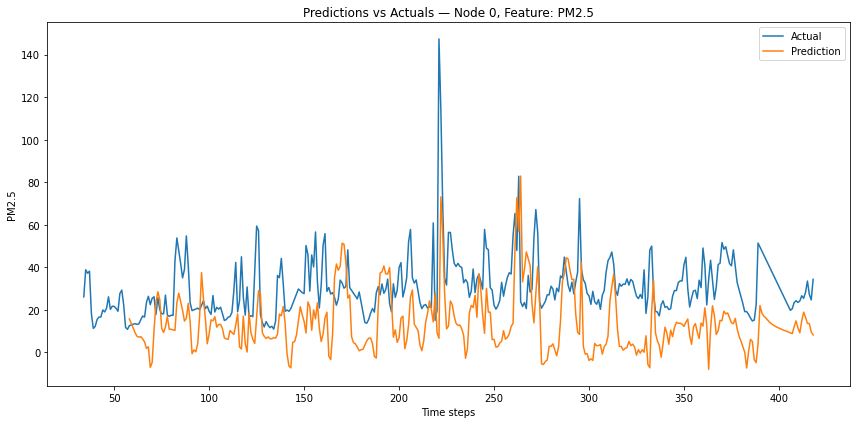

In [35]:
T, N, F = preds.shape
preds_2d = preds.reshape(-1, F)
trues_2d = trues.reshape(-1, F)
denorm_preds = global_scaler.inverse_transform(preds_2d).reshape(T, N, F)
denorm_trues = global_scaler.inverse_transform(trues_2d).reshape(T, N, F)
print("Denorm shapes:", denorm_preds.shape, denorm_trues.shape)

node_index = 0               # <-- choose the node (0..N-1); or: node_index = all_nodes.index(cell_id)
feature = 'PM2.5'             # 'PM2.5' | 'Humidity' | 'Temperature'
f_idx = FEATURES_READABLE.index(feature)

plt.figure(figsize=(12, 6))
plt.plot(denorm_trues[:, node_index, f_idx], label='Actual')
plt.plot(denorm_preds[:, node_index, f_idx], label='Prediction')
plt.xlabel('Time steps')
plt.ylabel(feature)
plt.title(f'Predictions vs Actuals — Node {node_index}, Feature: {feature}')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
torch.save(model.state_dict(), "final_model_state.pth")
